In [1]:
"""
COMP3170
Jialiang Hou
45996216
"""
# load necessary libraries
import random
import tensorflow as tf
import os
import tensorflow.keras.backend as K
import numpy as np

""" Input the images """

# The path of image
base = "./"
x_train_true = "train/AD"
x_train_false = "train/NC"
x_test_true = "test/AD"
x_test_false = "test/NC"


def img_shuffle(x, y):
    """
    shuffle the image.
    The given data are separated by AD and NC
    It needs to shuffle when combine to together
    :param x: the images [image1, image2, image3, ... imagen]
    :param y: the labels [label1, label2, label3, ... labeln]
    :return: images and labels after shuffle
    """
    pack = list(zip(x, y))
    random.shuffle(pack)
    x[:], y[:] = zip(*pack)
    return x, y


def load_path(path):
    """
    give a path of a folder return all the path of files in this folder
    :param path: a path of a folder
    :return: all the path of files in this folder
    """
    all_path = os.listdir(base + path)
    for i in range(len(all_path)):
        all_path[i] = base + path + '/' + all_path[i]
    return all_path


def process_image(x, y):
    """
    input the image path return the path and process it
    :param x: the path of images
    :param y: the labels
    :return: processed images and labels
    """
    image = tf.io.read_file(x)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, (60, 64))
    image = image / 255.0
    y = tf.cast(y, dtype=tf.uint8)
    return image, y


# load path of images
x_train_true = load_path(x_train_true)
# create array for label, set AD for true
y_train_true = np.ones(len(x_train_true))

x_train_false = load_path(x_train_false)
y_train_false = np.zeros(len(x_train_false))

x_test_true = load_path(x_test_true)
y_test_true = np.ones(len(x_test_true))

x_test_false = load_path(x_test_false)
y_test_false = np.zeros(len(x_test_false))

# shuffle the images
x_train, y_train = img_shuffle \
    (np.concatenate((x_train_true, x_train_false)), np.append(y_train_true, y_train_false))
x_test, y_test = img_shuffle \
    (np.concatenate((x_test_true, x_test_false)), np.append(y_test_true, y_test_false))

# create tensorflow dataset
# currently the dataset contains paths of image and their labels
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# use map to read the images
train = train.map(process_image)
test = test.map(process_image)

""" create train and test dataset """

# convert the tensorflow dataset from numpy array
train = np.array(list(train.as_numpy_iterator()))
test = np.array(list(test.as_numpy_iterator()))

import numpy.random as random

# lists for train and test
train_x1 = list()
train_x2 = list()
train_y = list()
test_x1 = list()
test_x2 = list()
test_y = list()

# create train dataset
for i in range(21520):  # there are 21520 samples in training set
    # choose 21520 random numbers from 0 to 21520
    index = random.randint(0, 21519, size=21520)
    # the indexed image
    train_x1.append(train[i][0])
    # the random image
    train_x2.append(train[index[i]][0])
    # define the label
    if train[i][1] == train[index[i]][1]:
        train_y.append(1)
    else:
        train_y.append(0)

for i in range(563):
    index = random.randint(0, 21519, size=21520)
    test_x1.append(train[i][0])
    test_x2.append(train[index[i]][0])
    if train[i][1] == train[index[i]][1]:
        test_y.append(1)
    else:
        test_y.append(0)

# finish the creating of train and test set
train_x1 = np.array(train_x1)
train_x2 = np.array(train_x2)
train_y = np.array(train_y)
test_x1 = np.array(test_x1)
test_x2 = np.array(test_x2)
test_y = np.array(test_y)

# kernel siz
kernel_size_1 = (8, 8)
kernel_size_2 = (6, 6)
kernel_size_3 = (4, 4)

# pool size
pool_size_1 = (6, 6)
pool_size_2 = (4, 4)

# strides
strides = 1

# define the structure of the layers
seq_conv_model = [
    # tf.keras.layers.Reshape( input_shape=(240,256,1) , target_shape=(120,128,1)),
    # convolutional layer
    tf.keras.layers.Conv2D(32, kernel_size=kernel_size_1, strides=strides, activation='relu'),
    # pool layer
    tf.keras.layers.MaxPooling2D(pool_size=pool_size_1, strides=strides),

    tf.keras.layers.Conv2D(64, kernel_size=kernel_size_2, strides=strides, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size_2, strides=strides),

    tf.keras.layers.Conv2D(128, kernel_size=kernel_size_3, strides=strides, activation='relu'),

    # flat the image to an one dimension array
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation=tf.keras.activations.sigmoid)
]

# define an instance of model
seq_model = tf.keras.Sequential(seq_conv_model)

# there are two input in Siamese network
input_x1 = tf.keras.layers.Input(shape=(60, 64, 1))
input_x2 = tf.keras.layers.Input(shape=(60, 64, 1))

# two inputs all should go through the model
output_x1 = seq_model(input_x1)
output_x2 = seq_model(input_x2)

# calculate the distance between the two outputs
distance_euclid = tf.keras.layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([output_x1, output_x2])
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(distance_euclid)
model = tf.keras.models.Model([input_x1, input_x2], outputs)

model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

# print the structure of model
model.summary()

model.fit([train_x1, train_x2], train_y, epochs=20, batch_size=16)

# print the training accuracy
metrics = model.evaluate([train_x1, train_x2], train_y)
print('Loss of {} and Accuracy is {} %'.format(metrics[0], metrics[1] * 100))

# print the test accuracy
metrics = model.evaluate([test_x1, test_x2], test_y)
print('Loss of {} and Accuracy is {} %'.format(metrics[0], metrics[1] * 100))


C:\Users\xxx\AppData\Local\Temp\ipykernel_13040\1829662016.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train = np.array(list(train.as_numpy_iterator()))
C:\Users\xxx\AppData\Local\Temp\ipykernel_13040\1829662016.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test = np.array(list(test.as_numpy_iterator()))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 64, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60, 64, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 256)          49916384    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 256)          0           ['sequential[0][0]',         

C:\Users\xxx\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
1345/1345 [==============================] - 43s 29ms/step - loss: 0.6789 - accuracy: 0.5657
Epoch 2/20
1345/1345 [==============================] - 39s 29ms/step - loss: 0.6360 - accuracy: 0.6395
Epoch 3/20
1345/1345 [==============================] - 40s 29ms/step - loss: 0.5610 - accuracy: 0.7138
Epoch 4/20
1345/1345 [==============================] - 40s 30ms/step - loss: 0.4796 - accuracy: 0.7738
Epoch 5/20
1345/1345 [==============================] - 40s 30ms/step - loss: 0.4035 - accuracy: 0.8207
Epoch 6/20
1345/1345 [==============================] - 41s 30ms/step - loss: 0.3242 - accuracy: 0.8635
Epoch 7/20
1345/1345 [==============================] - 41s 30ms/step - loss: 0.2585 - accuracy: 0.8952
Epoch 8/20
1345/1345 [==============================] - 41s 31ms/step - loss: 0.2019 - accuracy: 0.9223
Epoch 9/20
1345/1345 [==============================] - 41s 31ms/step - loss: 0.1517 - accuracy: 0.9474
Epoch 10/20
1345/1345 [==============================] - 41s 31m

C:\Users\xxx\Desktop\45996216-Siamese network\dataset.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train = np.array(list(train.as_numpy_iterator()))
C:\Users\xxx\Desktop\45996216-Siamese network\dataset.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test = np.array(list(test.as_numpy_iterator()))


673/673 [==============================] - 7s 11ms/step - loss: 0.0814 - accuracy: 0.9705
Loss of 0.08135543763637543 and Accuracy is 97.05390334129333 %
18/18 [==============================] - 0s 11ms/step - loss: 0.1025 - accuracy: 0.9556
Loss of 0.10248023271560669 and Accuracy is 95.55950164794922 %


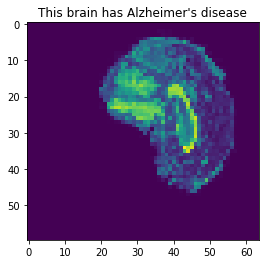

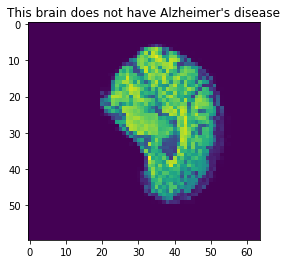

0

In [3]:
from matplotlib import pyplot as plt
import dataset


def prediction(model, image, known_images, show = True):
    """
    use the trained model to predict a single image weather the brain has AD
    :param image: image need to predict
    :param known_images: the image we know label in format:[AD,NC]
    :param show: whether to show this image
    :return: the predicted label
    """
    result = model.predict([np.array([known_images[0], known_images[1]]), np.array([image, image])])
    if show:
        plt.imshow(image)
        if result[0] > result[1]:
            plt.title("This brain has Alzheimer's disease")
        else:
            plt.title("This brain does not have Alzheimer's disease")
        plt.show()
    if result[0] > result[1]:
        return 1
    else:
        return 0


def process_predict_image(x):
    """
    input the image path return the image and process it
    :param x: the path of images
    :return: processed images
    """
    image = tf.io.read_file(x)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, (60, 64))
    image = image / 255.0
    return image


train_x1, train_x2, train_y, test_x1, test_x2, test_y = dataset.get_dataset()

# print the training accuracy
metrics = model.evaluate([train_x1, train_x2], train_y)
print('Loss of {} and Accuracy is {} %'.format(metrics[0], metrics[1] * 100))

# print the test accuracy
metrics = model.evaluate([test_x1, test_x2], test_y)
print('Loss of {} and Accuracy is {} %'.format(metrics[0], metrics[1] * 100))

image1 = process_predict_image("./test/AD/392277_97.jpeg")
image2 = process_predict_image("./test/NC/1188738_96.jpeg")
known_images = [process_predict_image("./train/AD/250168_103.jpeg"),process_predict_image("./train/NC/839474_87.jpeg")]

prediction(model,image1,known_images)
prediction(model,image2,known_images)